In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
from jax import nn

In [28]:
data = pd.read_csv('./digit-recognizer/train.csv')

In [47]:
data = jnp.array(data)
m, n = data.shape
shuffle_key = random.PRNGKey(100)
random.permutation(shuffle_key, data, independent=True) # shuffle before splitting into dev and training sets

train_data = data[1000:m].T
Y_train = train_data[0]
X_train = train_data[1:n]
X_train = X_train / 255.
_, m_train = X_train.shape

val_data = data[0:1000].T
Y_val = val_data[0]
X_val = val_data[1:n]
X_val = X_val / 255.

In [30]:
Y_train

DeviceArray([1, 0, 1, ..., 7, 6, 9], dtype=int32)

In [40]:
def init_params():
    key = random.PRNGKey(42)
    key, *subkey = random.split(key, 5)
    W1 = random.uniform(subkey[0], (10, 784), jnp.float32, -0.5, 0.5)
    b1 = random.uniform(subkey[1], (10, 1), jnp.float32, -0.5, 0.5)
    W2 = random.uniform(subkey[2], (10, 10), jnp.float32, -0.5, 0.5)
    b2 = random.uniform(subkey[3], (10, 1), jnp.float32, -0.5, 0.5)
    return W1, b1, W2, b2

def ReLU(Z):
    return jnp.maximum(Z, 0)

def softmax(Z):
    A = jnp.exp(Z) / sum(jnp.exp(Z))
    return A   

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = nn.one_hot(Y, Y.max() + 1)
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * jnp.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * jnp.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2


In [41]:
def get_predictions(A2):
    return jnp.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return jnp.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [44]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[3 3 3 ... 9 9 3] [1 0 1 ... 7 6 9]
0.10959524
Iteration:  10
[8 0 1 ... 1 6 6] [1 0 1 ... 7 6 9]
0.2405238
Iteration:  20
[8 0 1 ... 1 6 8] [1 0 1 ... 7 6 9]
0.3342619
Iteration:  30
[7 0 1 ... 7 6 8] [1 0 1 ... 7 6 9]
0.39069048
Iteration:  40
[7 0 1 ... 7 6 8] [1 0 1 ... 7 6 9]
0.4410476
Iteration:  50
[4 0 1 ... 7 6 7] [1 0 1 ... 7 6 9]
0.49369046
Iteration:  60
[8 0 1 ... 7 6 4] [1 0 1 ... 7 6 9]
0.53742856
Iteration:  70
[8 0 1 ... 7 6 4] [1 0 1 ... 7 6 9]
0.5740476
Iteration:  80
[1 0 1 ... 7 6 4] [1 0 1 ... 7 6 9]
0.60540473
Iteration:  90
[1 0 1 ... 7 6 4] [1 0 1 ... 7 6 9]
0.62819046
Iteration:  100
[1 0 1 ... 7 6 4] [1 0 1 ... 7 6 9]
0.64857143
Iteration:  110
[1 0 1 ... 7 6 4] [1 0 1 ... 7 6 9]
0.66578573
Iteration:  120
[1 0 1 ... 7 6 4] [1 0 1 ... 7 6 9]
0.68061906
Iteration:  130
[1 0 1 ... 7 6 4] [1 0 1 ... 7 6 9]
0.6927381
Iteration:  140
[1 0 1 ... 7 6 4] [1 0 1 ... 7 6 9]
0.7040476
Iteration:  150
[1 0 1 ... 7 6 4] [1 0 1 ... 7 6 9]
0.7147619
Iteration:

In [49]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [1]
Label:  1


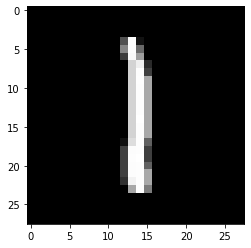

Prediction:  [8]
Label:  5


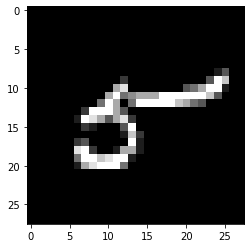

Prediction:  [1]
Label:  1


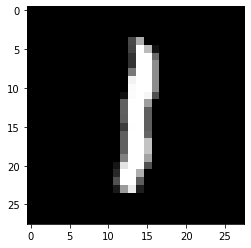

Prediction:  [7]
Label:  7


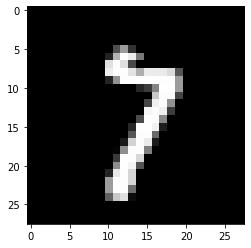

In [50]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [51]:
val_predictions = make_predictions(X_val, W1, b1, W2, b2)
get_accuracy(val_predictions, Y_val)

[1 0 1 2 0 0 7 3 5 3 8 9 1 3 3 1 8 0 7 6 8 6 2 0 3 3 6 9 9 7 8 9 4 9 6 1 3
 1 1 4 3 1 4 4 8 6 5 7 7 4 7 5 1 9 0 6 2 3 9 1 6 8 5 0 6 3 4 8 1 0 3 9 6 3
 2 4 9 1 4 1 8 4 8 9 2 3 9 8 9 6 8 6 4 6 9 7 1 2 0 5 9 2 7 7 4 8 8 5 0 6 0
 0 2 9 0 4 7 3 1 5 7 9 4 4 1 6 7 6 6 0 4 9 8 8 1 1 7 3 7 2 1 0 3 4 5 4 0 5
 4 0 3 5 1 0 8 3 7 0 9 6 6 9 8 9 6 9 3 5 4 2 4 8 7 4 5 8 8 8 2 6 9 3 1 0 4
 1 5 4 0 6 2 6 7 0 8 0 0 5 3 2 0 5 6 0 0 4 7 2 7 1 9 9 3 9 8 9 1 6 1 3 8 1
 8 7 1 3 7 6 3 2 3 4 3 2 3 6 2 7 9 2 2 2 7 3 6 8 9 2 0 1 4 8 6 3 7 1 1 1 4
 7 0 2 9 8 0 5 6 0 8 9 6 3 0 0 7 2 0 4 2 0 9 1 6 4 3 0 0 2 0 6 8 4 0 7 2 1
 9 5 2 4 8 5 2 9 7 9 2 9 7 4 9 3 2 1 3 6 3 6 8 8 3 7 0 9 2 7 4 0 9 4 6 8 4
 3 3 1 7 8 9 7 6 2 1 7 0 5 6 5 3 9 5 4 6 6 2 2 9 0 7 7 1 2 6 3 4 3 0 5 9 6
 2 1 9 0 6 0 9 5 4 3 1 5 4 2 9 5 7 3 1 5 9 5 3 7 3 8 6 4 4 6 1 1 4 0 0 5 8
 6 7 4 2 8 0 2 5 9 8 3 0 4 4 3 6 4 1 8 1 5 4 7 4 3 2 0 6 0 7 9 2 9 8 9 6 8
 2 4 4 6 4 8 4 1 7 5 8 4 5 9 9 3 5 8 2 2 7 2 8 9 1 9 3 6 0 2 2 9 1 2 7 2 1
 3 4 9 1 8 0 2 2 3 4 1 3 

DeviceArray(0.85300004, dtype=float32)